## Wstęp

#### Celem projektu jest predykcja cen nieruchomości oraz znalezienie wzorców i zależnośći między danymi.
#### Zbiór: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data

#### Zamierzone metody w celu osiągnięcia celu: regresja liniowa, regresja wielomianowa, regresja lasso, drzewa decyzyjne
#### Metody ewaluacji: bład ME, MAE, R^2 

#### Zmienne użyte w modelu:

***Zmienna zależna:***
- cena [$]

***Zmienne niezależne:***
- Liczba sypialni [szt]
- Liczba łazienek [szt]
- Powierzchnia domu [m^2]
- Powierzchnia działki [m^2]
- Liczba pięter [szt]
- Czy jest widok na wybrzeże (1-tak, 0-nie)
- Widok z domu (skala od 0-5, z czego 5-najładniejszy widok z domu)
- Stan domu (skala od 1-5)
- Jakość konstrukcji (skala od 1 do 13)
- Rok budowy [lata]
- Czy dom był remontowany (1-tak, 0-nie)
- Czy dom zawiera piwnice (1-tak, 0-nie)


## Pobranie danych (pobranie danych, zmiana nazw zmiennych)

In [8]:
!python --version # Python 3.12.7

In [9]:
import numpy as np 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=2, suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

In [10]:
df=pd.read_csv('kc_house_data.csv')
df.head()

In [11]:
nowe_nazwy={'date':'data_sprzedaży_domu', 'price':'cena', 'bedrooms':'sypialnie', 'bathrooms':'łazienki', 'sqft_living':'pow_domu',
       'sqft_lot':'pow_działki', 'floors':'piętra', 'waterfront':'widok_na_nabrzeże', 'view':'widok_z_domu', 'condition':'stan_domu',
       'grade':'jakość_konstrukcji',
       'sqft_above':'pow_nad_poziomem_gruntu', 'sqft_basement':'powierzchnia_pod_poziomem_gruntu',
       'yr_built':'rok_budowy', 'yr_renovated':'rok_ostatniego_remontu', 'zipcode':'kod_pocztowy',
       'lat':'szerokość_geograficzna', 'long':'długość_geograficzna', 'sqft_living15':'średnia_pow_domu_sąsiada', 
       'sqft_lot15':'średnia_pow_działki_sasiąda'}
df.rename(columns=nowe_nazwy,inplace=True)
df.columns

In [12]:
df.drop(columns=['id','data_sprzedaży_domu','kod_pocztowy',
       'szerokość_geograficzna', 'długość_geograficzna',
       'średnia_pow_domu_sąsiada', 'średnia_pow_działki_sasiąda'],inplace=True)

In [13]:
df.head()

In [14]:
# zamiana jednostek sqft na m^2
df['pow_domu']=df['pow_domu']*0.09290304
df['pow_działki']=df['pow_działki']*0.09290304
df['pow_nad_poziomem_gruntu']=df['pow_nad_poziomem_gruntu']*0.09290304
df['powierzchnia_pod_poziomem_gruntu']=df['powierzchnia_pod_poziomem_gruntu']*0.09290304

In [15]:
# dodanie nowej kolumny
df['czy_był_remont']=df['rok_ostatniego_remontu'].apply(lambda x: 0 if x == 0 else 1)

In [16]:
df.head()

In [17]:
df.drop(columns='rok_ostatniego_remontu',inplace=True)

In [18]:
df['czy_jest_piwnica']=df['powierzchnia_pod_poziomem_gruntu'].apply(lambda x: 0 if x == 0 else 1)

In [19]:
df.drop(columns=['pow_nad_poziomem_gruntu',	'powierzchnia_pod_poziomem_gruntu'],inplace=True)

In [20]:
df['łazienki'] = np.ceil(df['łazienki'])

In [21]:
df.head()

In [22]:
df.info()

## Przygotowanie danych (braki danych, wartości odstające, macierz korelacji, histogramy zmiennych)

### Braki danych

In [25]:
df.isnull().sum()

In [26]:
df.info()

### Wartości odstające

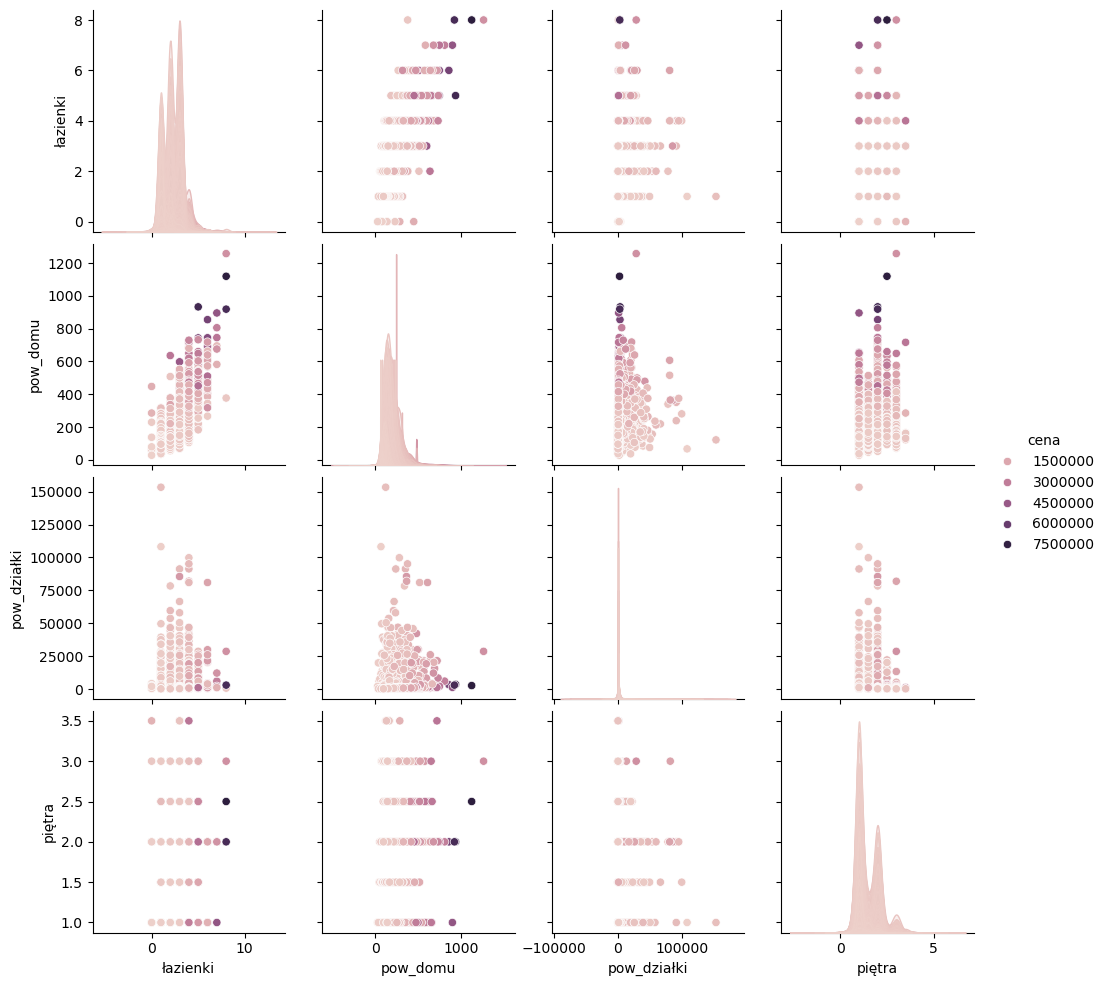

In [28]:
sns.pairplot(data=df.select_dtypes(include=['float64']), hue='cena')

In [29]:
kolumny=['cena', 'sypialnie', 'łazienki', 'pow_domu', 'piętra']
for i in kolumny:
    fig = px.box(data_frame=df, x=i, points="outliers",title=f'Wykres słupkowy pokazujący wartości odstające zmiennej {i}')
    fig.update_layout(title_x=0.5) 
    fig.show()

In [30]:
cleaned_df = df.copy() 

for i in kolumny:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_df = cleaned_df[(cleaned_df[i] >= lower_bound) & (cleaned_df[i] <= upper_bound)]

cleaned_df.head()
cleaned_df.info()

### Histogramy zmiennych

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_rows = len(cleaned_df.columns)

fig = make_subplots(
    rows=num_rows, cols=1,
    subplot_titles=[f'Histogram zmiennej {col}' for col in cleaned_df.columns]
)

for i, col in enumerate(cleaned_df.columns, start=1):
    fig.add_trace(
        go.Histogram(x=cleaned_df[col], name=col),
        row=i, col=1
    )
    fig.update_xaxes(title_text=col, row=i, col=1)
    fig.update_yaxes(title_text='Liczba obserwacji', row=i, col=1)

fig.update_layout(
    height=300 * num_rows, 
    width=1000, 
    title_text="Histogramy zmiennych",
    title_x=0.5, 
    showlegend=False  
)

fig.show()


### Macierz korelacji

In [34]:
df_float = cleaned_df.select_dtypes(include=['float64'])
corr_matrix = df_float.corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True, 
    aspect="auto",   
    color_continuous_scale='RdBu_r',  
    title="Macierz korelacji"
)
fig.show()

## Wykresy w celu znalezienia wzorców, zależnosci między danymi

In [36]:
fig = px.scatter(cleaned_df, x='pow_domu', y='cena', title='Zależność ceny od powierzchni domu', trendline='ols',
                 trendline_color_override='black',
                 labels={'pow_domu': 'Powierzchnia domu', 'cena': 'Cena nieruchomości'})
fig.update_layout(title_x=0.5)
fig.show()

In [37]:
fig = px.scatter(cleaned_df, x='pow_działki', y='cena', title='Zależność ceny od powierzchni działki', trendline='ols',
                 trendline_color_override='black',
                 labels={'pow_działki': 'Powierzchnia działki', 'cena': 'Cena nieruchomości'})
fig.update_layout(title_x=0.5)
fig.show()

In [38]:
bins = list(range(0, 2001, 500))
labels = ['0-500', '500-1000', '1000-1500', '1500-2000']
cleaned_df['pow_działki_przedziały'] = pd.cut(cleaned_df['pow_działki'], bins, labels=labels)

In [39]:
fig = px.bar(cleaned_df.groupby('pow_działki_przedziały').agg({'cena':'mean'}).reset_index(), x='pow_działki_przedziały', y='cena', 
             color='pow_działki_przedziały',
             title="Średnia cena w zależności od przedziałów powierzchni działki",
             labels={'pow_działki_przedziały': 'Przedziały powierzchni działki (m²)', 'cena': 'Średnia cena'})
fig.update_layout(title_x=0.5)
fig.show()

In [40]:
cleaned_df.drop(columns='pow_działki_przedziały',inplace=True)

In [41]:
fig = px.scatter_3d(cleaned_df, x='pow_domu', y='pow_działki', z='cena', 
                    title='Cena w zależności od powierzchni domu i działki',
                    labels={'pow_domu': 'Powierzchnia domu', 'pow_działki': 'Powierzchnia działki', 'cena': 'Cena nieruchomości'},
                     width=1000, height=800,color='cena')
fig.update_layout(title_x=0.5)
fig.show()

In [42]:
bins = list(range(1900, 2021, 10))  
labels = [f'{i}-{i+9}' for i in range(1900, 2020, 10)]  

cleaned_df['dekada'] = pd.cut(cleaned_df['rok_budowy'], bins=bins, labels=labels, right=False)

grouped_data = cleaned_df.groupby(['dekada']).size().reset_index(name='liczba_nieruchomosci')

fig = px.bar(grouped_data, 
             x='dekada', 
             y='liczba_nieruchomosci',
             title='Liczba nieruchomości w zależności od dekady budowy',
             labels={'dekada': 'Dekada budowy', 'liczba_nieruchomosci': 'Liczba nieruchomości'},
             color='dekada',
             width=1000, 
             height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [43]:
fig = px.bar(cleaned_df.groupby('dekada').agg({'cena': 'mean'}).reset_index(), 
             x='dekada', 
             y='cena',  
             title='Czy wiek nieruchomości ma wpływ na cenę?', 
             labels={'dekada': 'Wiek nieruchomości', 'cena': 'Cena nieruchomości'},
             color='dekada',
             width=1000, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [44]:
cleaned_df.drop(columns='dekada',inplace=True)

In [45]:
fig = px.bar(cleaned_df.groupby('widok_na_nabrzeże').agg({'cena': 'mean'}).reset_index(),
             x='widok_na_nabrzeże', 
             y='cena', 
             title='Czy domy z widokiem na nabrzeże są droższe?',
             labels={'widok_na_nabrzeże': 'Widok na nabrzeże', 'cena': 'Średnia cena'},
             color='widok_na_nabrzeże',  
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [46]:
fig = px.bar(cleaned_df.groupby('sypialnie').agg({'cena': 'mean'}).reset_index(), 
             x='sypialnie', 
             y='cena',  
             title='Czy liczba sypialni ma wpływ na cenę nieruchomości?', 
             labels={'sypialnie': 'Liczba sypialni', 'cena': 'Cena nieruchomości'},
             color='sypialnie',
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [47]:
fig = px.bar(cleaned_df.groupby('łazienki').agg({'cena': 'mean'}).reset_index(), 
             x='łazienki', 
             y='cena',  
             title='Cy liczba łazienek ma wpływ na cene nieruchomości?', 
             labels={'łazienki': 'Liczba łazienek', 'cena': 'Cena nieruchomości'},
             color='łazienki',
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [48]:
fig = px.bar(cleaned_df.groupby('czy_był_remont').agg({'cena': 'mean'}).reset_index(), 
             x='czy_był_remont', 
             y='cena',  
             title='Czy domy po remoncie są droższe?', 
             labels={'czy_był_remont': 'Remont', 'cena': 'Cena nieruchomości'},
             color='czy_był_remont',
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [49]:
fig = px.bar(cleaned_df.groupby('piętra').agg({'cena': 'mean'}).reset_index(), 
             x='piętra', 
             y='cena',  
             title='Kształtowanie się średniej ceny nieruchomości w zależności od liczby pięter', 
             labels={'Liczba pięter': 'piętra', 'cena': 'Cena nieruchomości'},
             color='piętra',
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

In [50]:
fig = px.bar(cleaned_df.groupby('czy_jest_piwnica').agg({'cena': 'mean'}).reset_index(), 
             x='czy_jest_piwnica', 
             y='cena',  
             title='Czy domy w piwnicą są droższe?', 
             labels={'czy_jest_piwnica': 'piwnica', 'cena': 'Cena nieruchomości'},
             color='czy_jest_piwnica',
             width=800, height=500)

fig.update_layout(title_x=0.5)
fig.show()

In [51]:
fig = px.bar(cleaned_df.groupby('stan_domu').agg({'cena': 'mean'}).reset_index(), 
             x='stan_domu', 
             y='cena',  
             title='Cena w zależności od stanu domu', 
             labels={'stan_domu': 'Stan domu', 'cena': 'Cena nieruchomości'},
             color='stan_domu',
             width=800, height=500)
fig.update_layout(title_x=0.5)
fig.show()

## Regresja liniowa - dobranie zmiennych do modelu, sprawdzenie założeń dotyczących regresji liniowej

In [53]:
cleaned_df.columns

In [54]:
regresja_liniowa = smf.ols(formula="cena ~ sypialnie + łazienki + pow_domu + pow_działki + piętra + C(widok_na_nabrzeże) + C(widok_z_domu) + C(stan_domu) + C(jakość_konstrukcji)+rok_budowy+C(czy_był_remont)+C(czy_jest_piwnica)", 
                           data=cleaned_df)
regresja_liniowa = regresja_liniowa.fit()
regresja_liniowa.summary()

In [55]:
### h0: zmienna nie jest istotna statystycznie
### h1: zmienna jest isotna statystycznie
### h0 odrzucamy kiedy p-value jest mniejsze niz 0,05
regresja_liniowa.pvalues

In [56]:
## Eliminaja wsteczna - ostateczny wynik

In [57]:
regresja_liniowa = smf.ols(formula="cena ~ sypialnie + łazienki + pow_domu + pow_działki + piętra + C(widok_z_domu) +rok_budowy+C(czy_jest_piwnica)", 
                           data=cleaned_df)
regresja_liniowa = regresja_liniowa.fit()
regresja_liniowa.pvalues

In [58]:
## zatem moj model regresji liniowej to: cena ~ sypialnie + łazienki + pow_domu + pow_działki + piętra + C(widok_z_domu) +rok_budowy+C(czy_jest_piwnica)

#### Normalność reszt - test Shapiro-Wilka

In [60]:
# h0: Reszty mają rozkład normalny
# h1: Reszty nie mają rozkładu normalnego

reszty = regresja_liniowa.resid

stat, p_value = stats.shapiro(reszty)
print(f"Shapiro-Wilk Test Statystyka: {stat}, p-value: {p_value}")

# p-value < 0.05, odrzucamy hipotezę o normalności rozkładu reszt.


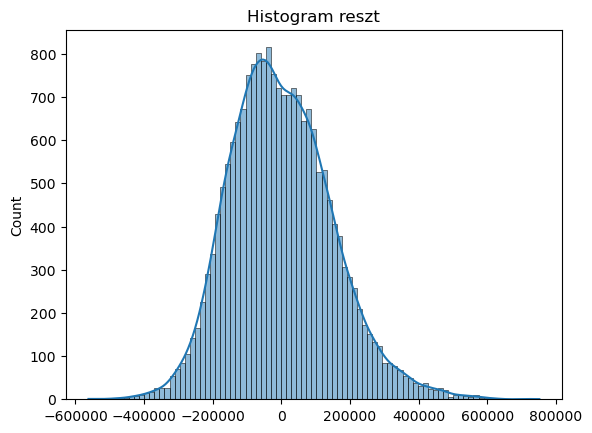

In [61]:
sns.histplot(reszty, kde=True)
plt.title('Histogram reszt')
plt.show()

#### Badanie homoskedastyczności

In [63]:
from statsmodels.stats.diagnostic import het_breuschpagan

# h0: homoskedastyczność (stała wariancja reszt)
# h1: heteroskedastyczność 

# Test Breuscha-Pagana
bp_test = het_breuschpagan(reszty, regresja_liniowa.model.exog)
bp_stat, bp_p_value, _, _ = bp_test
print(f"Test Breuscha-Pagana p-value: {bp_p_value}")

Test Breuscha-Pagana p-value: 5.138850482094248e-213


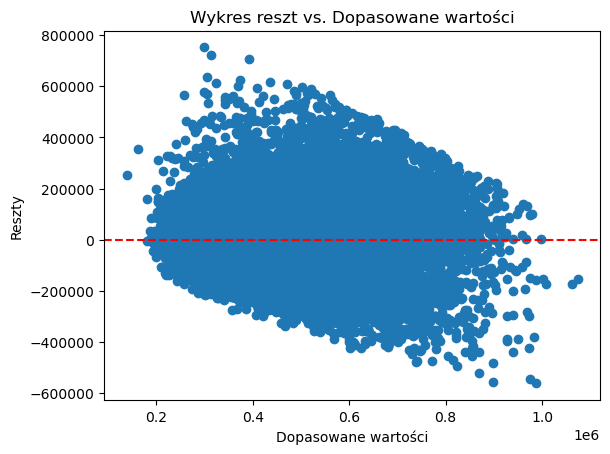

In [64]:
plt.scatter(regresja_liniowa.fittedvalues, reszty)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Dopasowane wartości")
plt.ylabel("Reszty")
plt.title("Wykres reszt vs. Dopasowane wartości")
plt.show()

#### Autokorelacja - test Durbina Watsona

In [66]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(reszty)
print(f"Statystyka Durbin-Watsona: {dw_stat}")

# Statystyka bliska 2, brak autokorelacji


Statystyka Durbin-Watsona: 1.974697241502082


In [67]:
# Wnioski: mimo moich prob (standaryzacja, pierwiastkowane,ogolnie skalowanie zmiennych) rozklad reszt nie jest rozkladem normalnym
# oraz wystepuje heteroskedastycznosc, wiec nie moge uzyc modelu regresjii liniowej

## Modelowanie (podział danych na treningowe, testowe i walidacyjne, modelowanie : regresja wielomianowa, regresja Lasso, drzewa decyzyjne)

### Podział danych na dane treningowe, testowe i walidacyjne

In [70]:
X = cleaned_df.drop(columns="cena")
y = cleaned_df.cena

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=22) # podzial wszystkich danych na treningowe i testowe

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=22) # podzial danych treningoweych na dane treningowe i walidacyjne

### Skalowanie danych

In [72]:
# skaluje dane zeby srednia=0 oraz odchylenie standardowe=1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # wszedzie ten sam skaler
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Regresja Wielomianowa

#### Wielomian stopnia 2

In [75]:
poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)  
X_valid_poly = poly.transform(X_valid)   

regresja_wielomianowa = LinearRegression()
regresja_wielomianowa.fit(X_train_poly, y_train) 

y_pred_walidacyjne = regresja_wielomianowa.predict(X_valid_poly)

In [76]:
r2 = regresja_wielomianowa.score(X_valid_poly, y_valid)
mae = mean_absolute_error(y_valid, y_pred_walidacyjne)
me = np.mean(y_valid - y_pred_walidacyjne)

In [77]:
wyniki_regresja_wielomianowa = pd.DataFrame({
    'Model':'Regresja wielomianowa',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

wyniki_regresja_wielomianowa


,Model,ME,MAE,R^2
0,Regresja wielomianowa,2774.33,102898.53,0.59


### Lasso

In [79]:
alfa = np.arange(0.1,10,0.1)
lista=[]
for i in alfa:
    model = Lasso(alpha=i)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    lista.append(mse)

In [80]:
alfa_df=pd.DataFrame({'alfa':alfa,'MSE':lista})

In [81]:
fig=px.line(data_frame=alfa_df,y='MSE',x='alfa',title='Błąd MSE w zależności od alfa')
fig.update_layout(title_x=0.5)
fig.show()

In [82]:
lasso_model = Lasso(alpha=9.7)

lasso_model.fit(X_train, y_train)

y_pred_walidacyjne = lasso_model.predict(X_valid)

In [83]:
r2 = lasso_model.score(X_valid, y_valid)
mae = mean_absolute_error(y_valid, y_pred_walidacyjne)
me = np.mean(y_valid - y_pred_walidacyjne)

In [84]:
wyniki_lasso = pd.DataFrame({
    'Model':'Lasso',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

wyniki_lasso

,Model,ME,MAE,R^2
0,Lasso,3780.91,105607.73,0.57


### Drzewa decyzyjne

In [86]:
max_głębokość = [1,2,3,4,5,6,7,8,9,10]
max_liście = [5,10,15,20,25,30,35]

głębokość = []
liście= []

for i in max_głębokość:
    model = DecisionTreeRegressor(max_depth=i)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    głębokość.append(mse)

for i in max_liście:
    model = DecisionTreeRegressor(max_leaf_nodes=i)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    liście.append(mse)

In [87]:
głębokość_df=pd.DataFrame({'głebokość':max_głębokość,'MSE':głębokość})
liście_df=pd.DataFrame({'liczba_liści':max_liście,'MSE':liście})

In [88]:
fig=px.line(data_frame=głębokość_df,y='MSE',x='głebokość',title='Błąd MSE w zależności od głebokości drzewa')
fig.update_layout(title_x=0.5)
fig.show()

In [89]:
fig=px.line(data_frame=liście_df,y='MSE',x='liczba_liści',title='Błąd MSE w zależności od liczby liści drzewa')
fig.update_layout(title_x=0.5)
fig.show()

In [90]:
model_drzewo = DecisionTreeRegressor(max_depth=6,max_leaf_nodes=25)
model_drzewo.fit(X_train, y_train)
y_pred_walidacyjne = model_drzewo.predict(X_valid)

In [91]:
r2 = model_drzewo.score(X_valid, y_valid)
mae = mean_absolute_error(y_valid, y_pred_walidacyjne)
me = np.mean(y_valid - y_pred_walidacyjne)

In [92]:
wyniki_drzewo= pd.DataFrame({
    'Model':'Drzewo decyzyjne',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

wyniki_drzewo

,Model,ME,MAE,R^2
0,Drzewo decyzyjne,2949.75,106748.06,0.55


In [93]:
wyniki_walidacyjne = pd.concat([wyniki_regresja_wielomianowa,wyniki_lasso,wyniki_drzewo], ignore_index=True)
wyniki_walidacyjne

## Ewaluacja: selekcja i ocena najlepszych modeli

In [95]:
## Regresja wielomianowa
X_test_poly = poly.transform(X_test) 
y_pred = regresja_wielomianowa.predict(X_test_poly)


r2 = regresja_wielomianowa.score(X_test_poly, y_test)
mae = mean_absolute_error(y_test, y_pred)
me = np.mean(y_test - y_pred)

wyniki_regresja_wielomianowa_test = pd.DataFrame({
    'Model':'Regresja wielomianowa',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

In [96]:
## Lasso
y_pred = lasso_model.predict(X_test)
r2 = lasso_model.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
me = np.mean(y_test - y_pred)

wyniki_lasso_test = pd.DataFrame({
    'Model':'Lasso',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

In [97]:
## Drzewo
y_pred_test = model_drzewo.predict(X_test)
r2 = model_drzewo.score(X_test, y_test)
mae = mean_absolute_error(y_test, y_pred)
me = np.mean(y_test - y_pred)

wyniki_drzewo_test= pd.DataFrame({
    'Model':'Drzewo decyzyjne',
    'ME':[me],
    'MAE': [mae],
    'R^2': [r2]
})

In [98]:
wyniki_test = pd.concat([wyniki_regresja_wielomianowa_test,wyniki_lasso_test,wyniki_drzewo_test], ignore_index=True)
wyniki_test

## Wnioski

##### Została wykonana regresja wielomianowa stopnia 2 (wyższe stopnie dawały gorsze wyniki), regresja metodą Lasso oraz regresja drzewem decyzyjnym.
##### Wspomniałam wcześniej, że regresja liniowa nie mogła zostać wykonana przez brak spełnienia założeń o normalności reszt oraz stałej wariancji reszt.

##### Najwiejszy wspołczynnik determinacji wynoszący 0.58 ma regresja wielomianowa. Oznacza to, że zmienność modelu została wyjaśniony w 58%.
##### Następnie w 57% model został wyjaśniony przeez algorytm Lasso, a w 52% przez algorytm drzewa decyzyjnego.

##### Najniższy błąd ME osiągnał algorytm regresji wielomianowej. Błąd ME<0 zatem
##### model przeszacowuje wartości, tzn. w przeważającej części przewiduje większe wartości niż rzeczywiste.
##### Model przeszacowuje wartości średnio o 772.86 jednostek (dolarów amerykańskich)

##### Podobnie jak w przypadku regresji wielomianowej, model Lasso i drzewa decyzyjnego mają taki sam bład błąd ujemny, 
##### co oznacza, że przewiduje wartości poniżej rzeczywistych o średnio 838.46 jednostek (dolarów amerykańskich) 

##### Dla regresji wielomianowej średni absolutny błąd  MAE wynosi 100 494.11, 
##### co oznacza, że na każdej próbce model popełnia średni błąd o tej wielkości, niezależnie od tego, czy błąd jest dodatni, czy ujemny.
##### Podobnie jest z pozostałymi algorytmami

##### Najlepszym modelem z tych trzech, jest model regresji wielomianowej, ponieważ ma najwyższy współczynik determinacji oraz najniższe błędy ME i MAE.
